# I - Checking the derivative expressions with Taylor tests

It is good practice to check the derivatives formula with Taylor tests. For a given $C^1$ function, the first order Taylor expansion reads 

$$ f(x+h) = f(x) + df(x) h + O(h^2) $$

So the Taylor remainder $ \mathcal R(x,h) = f(x+h) - f(x) - df(x) h $ should decrease quadratically with $h$.

In [1]:
from shapeOptInductor import gen_meshN, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt


We'll check our shape gradient expression on an arbitrary even number of control points $N$ along the air gap of the inductor.

In [2]:
np.random.seed(10) # for reproducibility, can be changed
##############################################
NControlPoints = (3+np.random.randint(5)) * 2 # arbitrary number of control points
##############################################
print(f"{NControlPoints = }")

NControlPoints = 8


___________________________
## 1 - Geometry and meshing

Then, we define the inductor geometry and generate the mesh.

In [3]:
# Geometric parameters
lz = 1e-2               # z-thickness of the inductor  
s = 4                   # symmetry factor (model 1/4th of the total space)

# Mesh generation
airgap = 4.11e-3 * np.ones(NControlPoints)              # Array of y-coordinates of control points along the airgap
maxh = 2e-3                                             # Maximum size of mesh element
mesh, p1, p2 = gen_meshN(airgap, maxh)                  # Generate the mesh and return the coordinates of control points on the first and second leg
xAirgaps = [p[0] for p in p1] + [p[0] for p in p2]      # Extract the x-coordinates of the control points

# Define the characteristics functions
XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})
materials_regions = 1 * XiAir + 2 * XiCoil + 3 * XiCore

# Draw the geometry and mesh
Draw(materials_regions, mesh, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

___________________________
## 2 - State problem (time-harmonic magnetics)

### 2.a - Parameters definition

First, we describe the magnetic permeabilities and the source currents.

In [4]:
# Electric current (assumed sinusoidal)
f = 5e4                                                         # Working frequency (Hz)
omega = 2 * np.pi * f                                           # rad/s
nb_turn = 200                                                   # Number of turn in the coil (no unit)
I = 2                                                           # Amplitude of the source current (A)
j = nb_turn / 2 * I / (ngs.Integrate(XiCoil, mesh)) * XiCoil    # Amplitude of the source current density  (A/m²)

# Magnetic permeabilities
mu0 = 4e-7 * np.pi                                              # Void permeability (H/m)
mur = 1000                                                      # Relative permeability of iron (no unit)
mu_iron = mur * mu0                                             # Iron permeability (H/m)
delta = 0.1                                                     # Loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0                             # Complex permeability of the coil

### 2.b - Definition of the time-harmonic magnetics problem

Then we can write the weak formulation and solve the following problem :
$$\text{Find } \underline{a_h} \in H := \{\underline{a} \in H^1(\Omega) |\, \underline{a} = 0 \text{ on } \Gamma_D\} \quad \text{ s.t. } \quad
    \forall \underline{v} \in H, \int_\Omega \underline{\nu_h} (\nabla \underline{a_h}) \cdot (\nabla \underline{v})^* \,\mathrm{d}x = \int_{\Omega_{c, h}} j \underline{v}^* \, \mathrm{d}x. $$

In [5]:
def magWeakFormComplex(ah : ngs.FESpace.TrialFunction, 
                       v  : ngs.FESpace.TestFunction
                       ) -> tuple[ngs.BilinearForm, ngs.LinearForm]:
    """Return the sybolic weak form of the magnetic problem, 
    i.e, bilinear and linear forms (not assembled yet)."""

    # Bilinear form (transmission)
    bf =  1 / mu_iron * ngs.grad(ah) * ngs.grad(v) * ngs.dx("core")
    bf += 1 / mu_coil * ngs.grad(ah) * ngs.grad(v) * ngs.dx("coil")
    bf += 1 / mu0 * ngs.grad(ah) * ngs.grad(v) * ngs.dx("air")

    # Linear form (source)
    lf = j * v * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh : ngs.Mesh
                      ) -> tuple[ngs.GridFunction, ngs.la.BaseMatrix]:
    """ Solve the time-harmonic magnetics problem """

    # Definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|domainVert", complex=True)
    a, v = fes.TnT()

    # Definition of weak form
    bf, f = magWeakFormComplex(a, v)

    # Assembly
    K = ngs.BilinearForm(bf).Assemble()
    F = ngs.LinearForm(f).Assemble()

    # Solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs())
    gf.vec.data = Kinv * F.vec

    return gf, Kinv  # returning Kinv speed up adjoint calculation

# Example :
state, Kinv = solveStateComplex(mesh)
Draw(state.real, mesh, radius=0.02, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 2.c - Definition of the post-processed quantities

We define the losses and inductance 
$$
\begin{array}{lcl}
P(\underline{a}) &=& \displaystyle  s l_z  \pi f \int_{\Omega_c} \text{Im} \left( \frac{1}{\underline{\mu_c}} \right ) |\nabla \underline{a}|^2 \;\mathrm{d}x,\\
L(\underline{a}) &=& \displaystyle \frac{s l_z}{I^2} \int_\Omega \text{Re} \left( \underline{\nu} \right) |\nabla \underline{a}|^2 \;\mathrm{d}x,\\
\end{array}$$

with their directional derivatives.

In [6]:
def L(state : ngs.GridFunction, 
      mesh : ngs.Mesh
      ) -> float:
    """ Compute inductance from the time-harmonic solution """
    nu = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (I**2) * ngs.Integrate(nu.real * ngs.Norm(ngs.grad(state)) ** 2, mesh)


def ddL(state : ngs.GridFunction, 
        v : ngs.FESpace.TestFunction
        ) -> ngs.comp.SumOfIntegrals:
    """ Compute directional derivative of the inductance from the time-harmonic solution """
    nu = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * s * lz / (I**2) * ngs.InnerProduct(nu.real * ngs.grad(state), ngs.grad(v)) * ngs.dx


def P(state : ngs.GridFunction,
      mesh : ngs.Mesh
      ) -> float:
    """ Compute AC losses in the conductor from the time-harmonic solution """
    nu = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(nu.imag * ngs.Norm(ngs.grad(state)) ** 2, mesh)


def ddP(state : ngs.GridFunction, 
        v : ngs.FESpace.TestFunction
        ) -> ngs.comp.SumOfIntegrals:
    """ Compute directional derivative of AC losses in the conductor from the time-harmonic solution """
    nu = XiCoil / mu_coil
    return 2 * s * np.pi * f * lz * ngs.InnerProduct(nu.imag * ngs.grad(state), ngs.grad(v)) * ngs.dx

# Example :
print(f"Inductance : {L(state, mesh) *1000:.3} mH")
print(f"Losses : {P(state, mesh):.3} W")

Inductance : 1.0 mH
Losses : 13.2 W


___________________________
## 3 - Adjoint problem

The adjoint method is an efficient way to compute derivatives of PDE-constrained problem; it requires solving one linear auxiliary problem per function $f$ to derivate that reads

$$ \text{Find } \underline{p}_f \in H \quad \text{ s.t. } \quad
    \forall \underline{v} \in H,  \quad \int_\Omega \nabla \underline{p}_f \cdot \underline{\nu}^* \nabla \underline{v} \; \mathrm{d}x = \int f'(\underline{a})(\underline{v})\; \mathrm{d}x, $$

with $f'$ the directional derivative of $f$, such that $F(\underline{a}) = \int_\Omega f(\underline{a}) \; \mathrm{d}x$.

In [7]:
def solveAdjoint(state : ngs.GridFunction,      
                 df : ngs.comp.SumOfIntegrals,
                 Kinv : ngs.la.BaseMatrix
                 ) -> ngs.GridFunction:
    """Solve the adjoint equation for a given directional derivative (right-hand side)"""

    fes = state.space
    v = fes.TestFunction()

    # Assemble the right-hand side
    f = ngs.LinearForm(-1. * df(state, v)).Assemble()
    
    # Solve using the adjoint (transconjugate) of provided FEM matrix
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec

    return gf

# Example :
adjoint_P = solveAdjoint(state, ddP, Kinv)
Draw(adjoint_P.real, mesh, radius = 0.02, settings = {"Objects" : { "Wireframe" : False }})

adjoint_L = solveAdjoint(state, ddL, Kinv)
Draw(adjoint_L.real, mesh, radius = 0.02, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

___________________________
## 4 - Continuous and discretized shape derivatives

### 4.a - Continuous expressions

The shape derivative of the losses is a linear form obtained by Céa's method that reads
$$\mathrm{d} P(\Omega)(\phi) = \text{Re}\left( s l_z \pi f \int_{\Omega_c} \text{Im}\left(\frac{1}{\underline{\mu_c}}\right) A_\phi \nabla \underline a \cdot (\nabla \underline a)^* \; \mathrm{d} x + \int_\Omega \underline{\nu} A_\phi \nabla \underline{a} \cdot \nabla \underline p_P^* \mathrm{d} x - \int_{\Omega_c} j\, \text{div} \phi\, \underline p_P^*  \mathrm{d} x \right)  $$

with $\phi\in W^{1, \infty}(\mathbb{R}^2, \mathbb{R}^2)$ and $A_\phi = \text{div} \phi \, I_2 - \nabla \phi - \nabla \phi^\top$.

In [8]:
def sdP(state : ngs.GridFunction,
        adjoint_P : ngs.GridFunction
        ) -> ngs.LinearForm :
    """ Compute the shape derivative (linear form) of the AC losses inside the coil """

    # Finite element spaces
    mesh = state.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    phi = FEScomplex.TestFunction()

    # Shorthands
    nu = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_losses = s * np.pi * f * lz * (1 / mu_coil).imag
    dA = ngs.div(phi) * Id - ngs.grad(phi) - ngs.grad(phi).trans

    # Shape derivative
    shape_derivative_cplx = ngs.LinearForm(FEScomplex)
    shape_derivative_cplx += coeff_losses * ngs.InnerProduct(dA * ngs.grad(state), ngs.grad(state)) * ngs.dx("coil")
    shape_derivative_cplx += -j * XiCoil * ngs.div(phi) * adjoint_P * ngs.dx
    shape_derivative_cplx += ngs.InnerProduct(nu * dA * ngs.grad(state), ngs.grad(adjoint_P)) * ngs.dx
    shape_derivative_cplx.Assemble()

    # Take the real part
    shape_derivative = ngs.LinearForm(FESReal)
    shape_derivative.vec.FV().NumPy()[:] = np.real(shape_derivative_cplx.vec.FV().NumPy()[:])

    return shape_derivative

Similarly, computing the shape derivative of the inductance leads to

$$ 
 \mathrm{d}  L(\Omega)(\phi) =  \text{Re}\left( \frac{s l_z}{I^2} \int_\Omega \underline{\nu} A_\phi \nabla \underline{a} \cdot (\nabla \underline a)^* \; \mathrm{d} x  + \int_\Omega \underline{\nu} A_\phi \nabla \underline{a} \cdot \nabla \underline p_L^* \mathrm{d} x - \int_{\Omega_c} j\,\text{div} \phi\, \underline p_L^*  \mathrm{d} x \right) 
$$

In [9]:
def sdL(state : ngs.GridFunction,
        adjoint_L : ngs.GridFunction
        ) -> ngs.LinearForm :
    """ Compute the shape derivative (linear form) for the inductance"""

    # Finite element spaces
    mesh = state.space.mesh
    FEScomplex = ngs.H1(mesh, complex = True)**2 #ngs.VectorH1(mesh, complex=True)
    FESReal = ngs.H1(mesh)**2 # ngs.VectorH1(mesh)
    phi = FEScomplex.TestFunction()

    # Shorthands
    nu = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_induc = s * lz / (I**2) * nu.real
    dA = ngs.div(phi) * Id - ngs.grad(phi) - ngs.grad(phi).trans

    # Shape derivative 
    shape_derivative_cplx = ngs.LinearForm(FEScomplex)
    shape_derivative_cplx += coeff_induc * ngs.InnerProduct(dA * ngs.grad(state), ngs.grad(state)) * ngs.dx
    shape_derivative_cplx += -j * ngs.div(phi) * adjoint_L * ngs.dx
    shape_derivative_cplx += ngs.InnerProduct(nu * dA * ngs.grad(state), ngs.grad(adjoint_L)) * ngs.dx
    shape_derivative_cplx.Assemble()
    shape_derivative = ngs.LinearForm(FESReal)
    shape_derivative.vec.FV().NumPy()[:] = np.real(shape_derivative_cplx.vec.FV().NumPy()[:])

    return shape_derivative

### 4.b - Discrete shape derivatives
- The shape derivative is a **linear form**, from which we can extract a **descent direction**.
- At the discrete level, one possibility is to extract directly the **nodal coefficients** from the assembled linear form, which is a vector.
    - It represents the derivative of the losses with respect to the **coordinates of the mesh nodes**. In a sense, it represents the **shape gradient** of the discretized model.
    - It takes the form of a nodal vector field, indicating in which direction one should move every node of the mesh to increase $f$ maximally.
- We can therefore plot it, as below. It is almost 0 everywhere (should be exactly 0 up to the discretization errors), except on the **edges** of the geometry. 
    - Indeed, displacing a node at an interface modify the material distribution, which impacts the value of the scalar function, while moving a point from the inside doesn't change the geometry.
- The **correctness** of the point-wise values of the discretized shape derivative can therefore be checked by **finite difference**, which is the purpose of the last section.

In [10]:
# Nodal identification of the shape derivative of the losses:
sdP_linear_form = sdP(state, adjoint_P)
discrete_shape_gradient_P = ngs.GridFunction(sdP_linear_form.space)
discrete_shape_gradient_P.vec.data = sdP_linear_form.vec
Draw(discrete_shape_gradient_P, mesh, radius = 0.02, vectors={"grid_size":100}, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [11]:
# Nodal identification of the shape derivative of the inductance:
sdL_linear_form = sdL(state, adjoint_L)
discrete_shape_gradient_L = ngs.GridFunction(sdL_linear_form.space)
discrete_shape_gradient_L.vec.data = sdL_linear_form.vec
Draw(discrete_shape_gradient_L, mesh, radius = 0.02, vectors={"grid_size":100}, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 4.c - Sensitivities with respect to the control points

The sensitivities with respect to the $y$-coordinate of the control points (i.e., the first order derivatives of the quantity of interest) are simply obtained by taking the scalar product of the discretized shape derivative with a displacement field induced by the displacement of the control points.

To obtain the true derivative, the displacement of the control point should be unitary. In the literature, this displacement can also be called a "velocity" because it can be used as a descent direction, transporting the geometry through a pseudo-time that are iterations of the algorithm. It is also possible (rather recommended) to use other descent direction using a regularization.

In [12]:
from shapeOptInductor import referenceVelocity

def sensitivities_y_control_points(state : ngs.GridFunction,
               adjoint : ngs.GridFunction,
               shape_derivative : callable,
               x_airgap : list[float]) -> list[float]:
    """ Compute the sensitivities of a function with respect to the y-value of the control points """

    velocityFields = referenceVelocity(state.space.mesh, x_airgap)
    sd_linearform = shape_derivative(state, adjoint)
    sd_discretized = ngs.GridFunction(ngs.VectorH1(state.space.mesh))
    sd_discretized.vec.FV().NumPy()[:] = np.real(sd_linearform.vec.FV().NumPy()[:])
    sensitivities = [ ngs.InnerProduct(sd_discretized.vec, refVelocity.vec) for refVelocity in velocityFields]
    return sensitivities

# Example:
sensitivities_P = sensitivities_y_control_points(state, adjoint_P, sdP, xAirgaps)
sensitivities_L = sensitivities_y_control_points(state, adjoint_L, sdL, xAirgaps)

print("dL/dy = [ " + ', '.join(f"{k:.3e}" for k in sensitivities_P) + " ]")
print("dP/dy = [ " + ', '.join(f"{k:.3e}" for k in sensitivities_L) + " ]")

dL/dy = [ 2.129e+02, 4.156e+02, 1.536e+02, -2.460e+03, -1.554e+03, -4.265e+02, -2.948e+02, -2.977e+02 ]
dP/dy = [ -3.563e-02, -7.161e-02, -7.899e-02, -7.990e-02, -3.416e-02, -3.382e-02, -3.387e-02, -3.488e-02 ]


_____________________
## 5 - Taylor tests

### 5.a - Compute Taylor remainders

The purpose of this section is to check the expression of the shape derivatives, by computing the decrease of the Taylor remainder of the associated sensitivities with respect to the control points.

In [13]:
# Choose the function to check
nTest = 0  # 0 : inductance, 1 : losses

# unperturbed state (reference)
airgap = 4.11e-3 * np.ones(NControlPoints)
mesh, _, _ = gen_meshN(airgap, maxh)
reference_state, Kinv = solveStateComplex(mesh)

# select appropriate callable for the quantity, directional derivative and shape derivative
if nTest == 0:
    J, ddJ, sdJ = L, ddL, sdL
elif nTest == 1:
    J, ddJ, sdJ = P, ddP, sdP

# sensitivities
F0 = J(reference_state, mesh)
adjoint = solveAdjoint(reference_state, ddJ, Kinv)
dF = sensitivities_y_control_points(reference_state, adjoint, sdJ, xAirgaps)

In [14]:
# taylor tests
N_taylor_points = 10
H = np.logspace(-11, -2, N_taylor_points)

# perturbed computations
velocity_list = referenceVelocity(mesh, xAirgaps)
J_list = [[] for i in range(NControlPoints)]
velocity = ngs.GridFunction(ngs.VectorH1(mesh))
taylor_remainders_list = [[] for i in range(NControlPoints)]

# compute the sensitivity by finite difference
for k, h in enumerate(H):
    for i in range(NControlPoints):
        velocity.Set(velocity_list[i] * h)
        mesh.SetDeformation(velocity)
        perturbed_state, _ = solveStateComplex(mesh)
        J_list[i].append( J(perturbed_state, mesh) )
        taylor_remainders_list[i].append(np.array(J_list[i][-1]) - F0 - dF[i] * h)
        mesh.UnsetDeformation()
    print("Computing ... [" + ("===="*(k+1)) + ("    "*(N_taylor_points-k-1)) + "]" ,end="\r")

### 5.b - Plot and check
 The expressions are correct if the decrease of Taylor remainder is **quadratic**, until floating point errors appears when $h$ becomes very small (around $10^{-8}$).

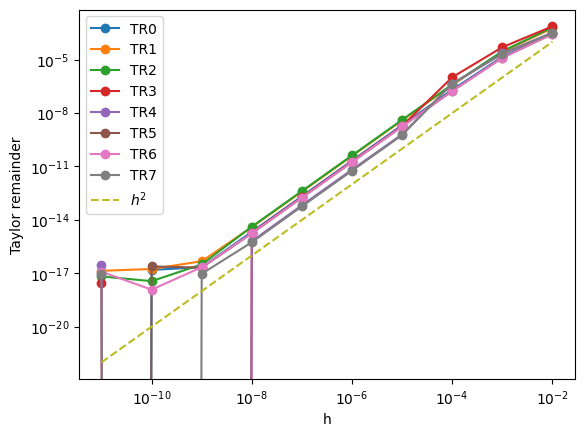

In [15]:
# Display

for i in range(NControlPoints):
    plt.loglog(H, taylor_remainders_list[i], "-o", label="TR"+str(i))
plt.xlabel("h")
plt.ylabel("Taylor remainder")
plt.loglog(H, H**2, "--", label="$h^2$")
plt.legend()
plt.show()